## Notebook for visualizing attention transform across CLIP layers

In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import CLIPProcessor, CLIPModel

/home/daniel/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


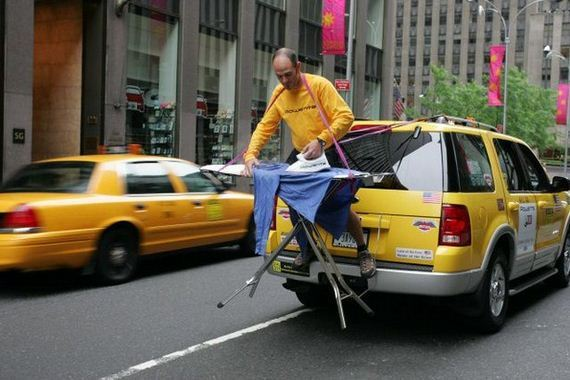

In [2]:
image_path = "../assets/extreme-ironing.png"
image = Image.open(image_path)
image

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "openai/clip-vit-large-patch14-336"
model = CLIPModel.from_pretrained(model_name, output_attentions=True).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Attention rankings of different layers

In [4]:
def get_attention_ranks(model, processor, image):
    inputs = processor(images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.vision_model(**inputs, output_attentions=True)

    attentions = outputs.attentions  # Tuple of (batch, heads, seq_len, seq_len)

    attention_maps = []
    for layer_attn in attentions:
        layer_avg_attn = layer_attn.mean(dim=1).squeeze(0)  # (seq_len, seq_len)
        attn_score = layer_avg_attn.sum(0)[1:]
        
        # Transform into ranks for better visualization
        # [0.2, 0.4, 0.3, 0.1] -> [1, 3, 2, 0]
        attn_score = torch.argsort(torch.argsort(attn_score)).float()
        attention_maps.append(attn_score.cpu().numpy())
    
    return attention_maps

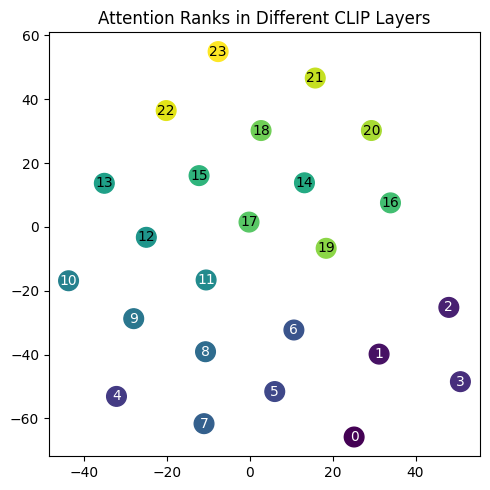

In [5]:
attention_ranks = get_attention_ranks(model, processor, image)

X = np.stack(attention_ranks, axis=0)
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=range(len(attention_ranks)), cmap='viridis', s=200)

for i, (x, y) in enumerate(X_tsne):
    plt.text(x, y, str(i), fontsize=10, ha='center', va='center', color='white' if i < len(attention_ranks)/2 else 'black')

plt.title('Attention Ranks in Different CLIP Layers')
plt.tight_layout()

### Top 50% attentive tokens from different CLIP layers

In [6]:
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt", padding=True).to(device)
    outputs = model.vision_model(**inputs, output_attentions=True, output_hidden_states=True)

    all_attentions = outputs.attentions  
    patch_tokens = outputs.hidden_states[-2]
    
patch_tokens = patch_tokens[:, 1:]
patch_tokens = patch_tokens.squeeze(0).cpu().numpy()
num_patches = patch_tokens.shape[0]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
patch_tokens_2d = tsne.fit_transform(patch_tokens)

In [7]:
def get_top_attention_tokens(attention_weights, top_percent=0.5):
    token_scores = attention_weights[0].mean(0).sum(0)[1:]
    top_k = max(1, int(len(token_scores) * top_percent))
    top_indices = torch.topk(token_scores, k=top_k).indices
    return top_indices.cpu().numpy()

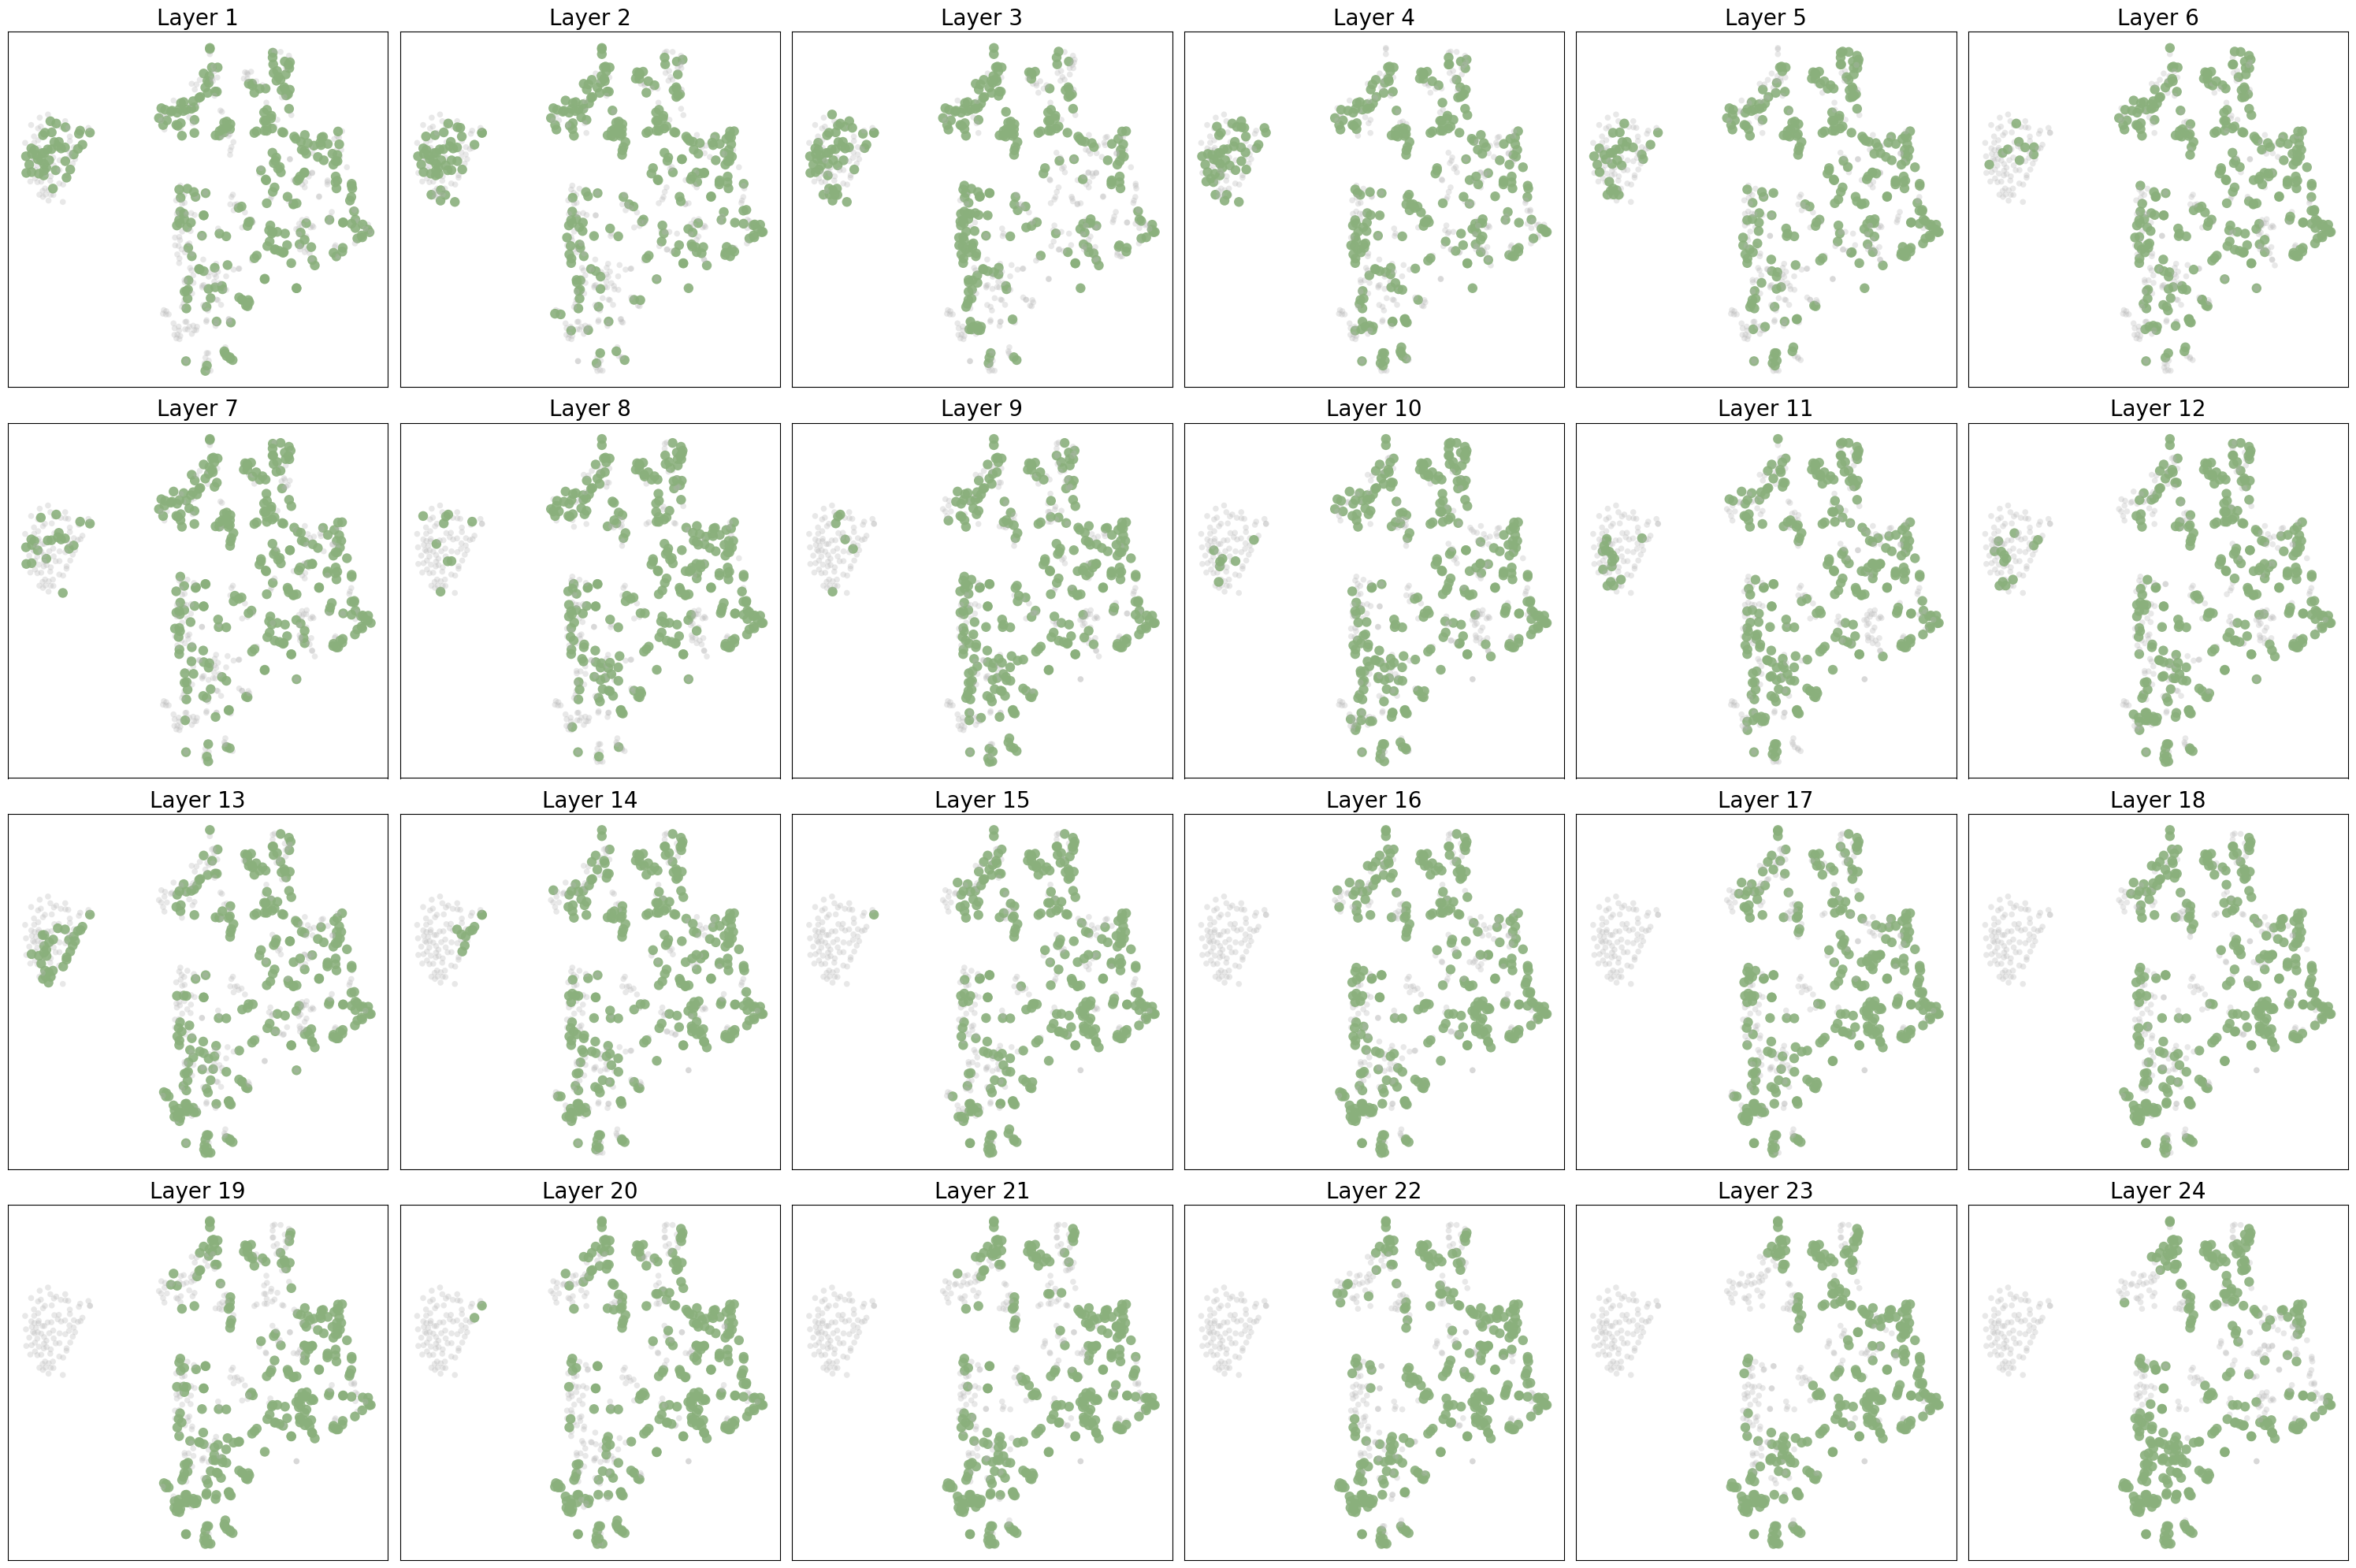

In [8]:
num_layers = len(all_attentions)
cols = 6
rows = (num_layers + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 5))

for layer_idx in range(num_layers):
    top_indices = get_top_attention_tokens(all_attentions[layer_idx])

    ax = plt.subplot(rows, cols, layer_idx + 1)

    colors = np.array(["#B5B5B5"] * num_patches)
    sizes = np.array([30] * num_patches)
    alphas = np.array([0.3] * num_patches)
    
    colors[top_indices] = "#8ab07c"
    sizes[top_indices] = 80
    alphas[top_indices] = 0.9
    
    ax.scatter(
        patch_tokens_2d[:, 0], 
        patch_tokens_2d[:, 1],
        c=colors,
        s=sizes,
        alpha=alphas,
        edgecolors='none'
    )
    
    ax.set_title(f"Layer {layer_idx + 1}", fontsize=20)
    ax.grid(True, alpha=0.2)

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()